In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random


In [3]:
# Load and preprocess data
ROOT_PATH = "/content/drive/MyDrive/image_processing_project"
train_data_dir = os.path.join(ROOT_PATH, "Training")
test_data_dir = os.path.join(ROOT_PATH, "Testing")


In [4]:
# Function to load and resize image data
def load_data(data_directory, target_size=(100, 100)):
    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)
                      if f.endswith(".ppm")]
        for f in file_names:
            img = cv2.imread(f)
            img_resized = cv2.resize(img, target_size)  # Resize images to a consistent size
            images.append(img_resized)
            labels.append(int(d))
    return images, labels


In [5]:
# Load data with resizing
train_images, train_labels = load_data(train_data_dir)
test_images, test_labels = load_data(test_data_dir)


In [6]:
# Flatten images for KMeans
X_train_kmeans = np.array([image.flatten() for image in train_images])
X_test_kmeans = np.array([image.flatten() for image in test_images])


In [8]:
#print("Shape of X_train_lr_flat:", X_train_lr_flat.shape)


In [9]:
# Apply KMeans clustering
NUM_CLASSES = 62  # Adjust this based on your dataset
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=1111)
train_cluster_labels = kmeans.fit_predict(X_train_kmeans)
test_cluster_labels = kmeans.predict(X_test_kmeans)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
# Example: Print cluster assignments for the first 10 samples in the test set
print("Test Set Cluster Assignments:", test_cluster_labels[:10])


Test Set Cluster Assignments: [45 45  8 18 18  8  8 18  3 18]


In [1]:
# Visualize a few random samples and their cluster assignments
random_indices = random.sample(range(len(test_images)), 5)
for i in random_indices:
    image = test_images[i]
    cluster_label = test_cluster_labels[i]
    plt.imshow(image)
    plt.title(f"Cluster: {cluster_label}")
    plt.show()


NameError: name 'random' is not defined

In [12]:
# Use cluster assignments as features
X_train_combined = np.hstack((X_train_kmeans, train_cluster_labels.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_kmeans, test_cluster_labels.reshape(-1, 1)))


In [13]:
# Train Logistic Regression on the combined features
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_combined, train_labels)


LogisticRegression(max_iter=1000)

In [14]:
# Evaluate on the test set
predictions = logistic_regression_model.predict(X_test_combined)
accuracy = accuracy_score(test_labels, predictions)
print(f"Testing Accuracy: {accuracy}")

Testing Accuracy: 0.9166666666666666


In [15]:
# Calculate and print KMeans clustering accuracy
kmeans_accuracy = accuracy_score(test_labels, test_cluster_labels)
print(f"KMeans Clustering Accuracy: {kmeans_accuracy}")


KMeans Clustering Accuracy: 0.005952380952380952


In [16]:
from skimage.feature import hog
from skimage import exposure


In [17]:
# Function to extract HOG features from an image
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply HOG feature extraction
        features, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(8, 8),
                                  cells_per_block=(1, 1), visualize=True)

        # Reshape the features and append to the list
        hog_features.append(features)

    return np.array(hog_features)


In [18]:
# Extract HOG features for training and testing images
train_hog_features = extract_hog_features(train_images)
test_hog_features = extract_hog_features(test_images)


In [19]:
# Apply KMeans clustering on HOG features
NUM_CLASSES = 62
kmeans_hog = KMeans(n_clusters=NUM_CLASSES, random_state=1111)
train_cluster_labels_hog = kmeans_hog.fit_predict(train_hog_features)
test_cluster_labels_hog = kmeans_hog.predict(test_hog_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


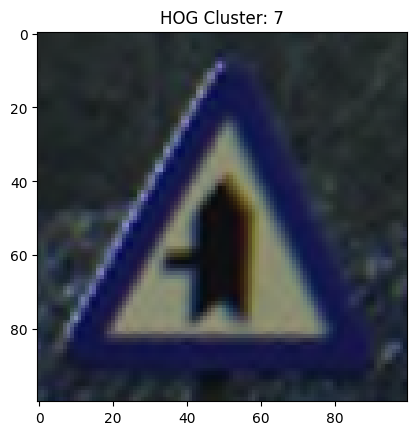

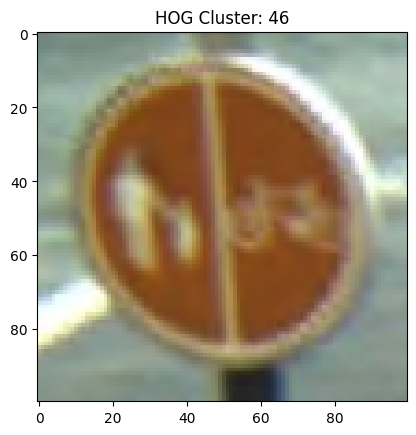

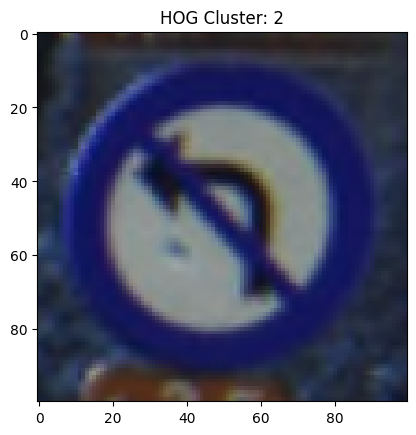

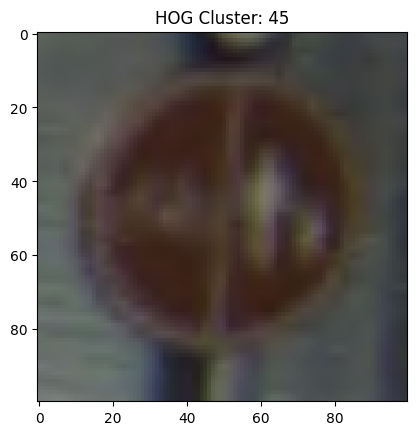

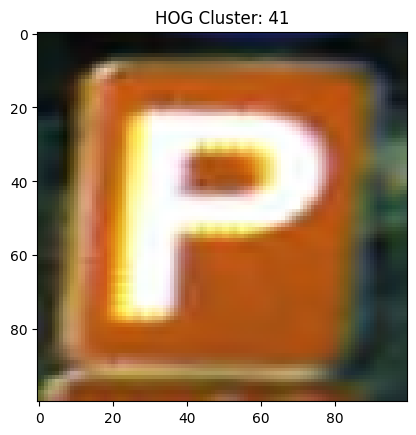

In [20]:
# Visualize a few random samples and their cluster assignments
random_indices_hog = random.sample(range(len(test_images)), 5)
for i in random_indices_hog:
    image = test_images[i]
    cluster_label_hog = test_cluster_labels_hog[i]
    plt.imshow(image)
    plt.title(f"HOG Cluster: {cluster_label_hog}")
    plt.show()


In [21]:
# Use HOG cluster assignments as features
X_train_combined_hog = np.hstack((train_hog_features, train_cluster_labels_hog.reshape(-1, 1)))
X_test_combined_hog = np.hstack((test_hog_features, test_cluster_labels_hog.reshape(-1, 1)))


In [22]:
# Train Logistic Regression on the combined features
logistic_regression_model_hog = LogisticRegression(max_iter=1000)
logistic_regression_model_hog.fit(X_train_combined_hog, train_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [23]:
# Evaluate on the test set
predictions_hog = logistic_regression_model_hog.predict(X_test_combined_hog)
accuracy_hog = accuracy_score(test_labels, predictions_hog)
print(f"Testing Accuracy with HOG: {accuracy_hog}")

Testing Accuracy with HOG: 0.932936507936508
